<a href="https://colab.research.google.com/github/Camel-light/Assignments/blob/main/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Framing the Problem
In the previous homework we used a linear & random forest models to estimate housing prices. This time, do the same but on a different dataset.

The CalCOFI data set is a long and complete time series of oceanographic and larval fish data that has been collected since 1949. It includes data on the abundance of fish larvae, larval length frequency, egg abundance, and oceanographic and plankton data. 

We will use this dataset to study if there a relationship between water salinity & water temperature? Can we predict the water temperature based on salinity?

The following code imports some packages, mounts the Google Drive folder and loads the data. 

In [10]:
import pandas as pd
import numpy as np
from google.colab import drive
from google.colab import data_table
import matplotlib.pyplot as plt

data_table.enable_dataframe_formatter()

drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Lab3/bottle.csv")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-10-5fa7d467d20d>:10: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Lab3/bottle.csv")


We look at summaries of the data: head(), describe(), info()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 74 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Cst_Cnt              864863 non-null  int64  
 1   Btl_Cnt              864863 non-null  int64  
 2   Sta_ID               864863 non-null  object 
 3   Depth_ID             864863 non-null  object 
 4   Depthm               864863 non-null  int64  
 5   T_degC               853900 non-null  float64
 6   Salnty               817509 non-null  float64
 7   O2ml_L               696201 non-null  float64
 8   STheta               812174 non-null  float64
 9   O2Sat                661274 non-null  float64
 10  Oxy_µmol/Kg          661268 non-null  float64
 11  BtlNum               118667 non-null  float64
 12  RecInd               864863 non-null  int64  
 13  T_prec               853900 non-null  float64
 14  T_qual               23127 non-null   float64
 15  S_prec           

As we can see, the dataset contains 74 columns, which are so many there are issues representing them all!

Let's extract just salinity and temperature. They are called '*T_degC*', '*Salnty*'.



In [12]:
temp_salinity_df = data[['T_degC','Salnty']]

In [13]:
temp_salinity_df.head(10)

,T_degC,Salnty
0,10.50,33.440
1,10.46,33.440
2,10.46,33.437
3,10.45,33.420
4,10.45,33.421
5,10.45,33.431
6,10.45,33.440
7,10.24,33.424
8,10.06,33.420
9,9.86,33.494


In [14]:
temp_salinity_df.describe()


,T_degC,Salnty
count,853900.000000,817509.000000
mean,10.799677,33.840350
std,4.243825,0.461843
min,1.440000,28.431000
25%,7.680000,33.488000
50%,10.060000,33.863000
75%,13.880000,34.196900
max,31.140000,37.034000


We can notice that *Salnty* has a much lower standard deviation than the temperature.

In [15]:
temp_salinity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   T_degC  853900 non-null  float64
 1   Salnty  817509 non-null  float64
dtypes: float64(2)
memory usage: 13.2 MB


In [16]:
# pd.set_option('display.max_rows', None) # Only needed if running corr() on entire data
corr_matrix = temp_salinity_df.corr()
corr_matrix["T_degC"].sort_values(ascending=False)

T_degC    1.000000
Salnty   -0.505266
Name: T_degC, dtype: float64

Lets plot them. We notice that the temperature has a  right skew and that the salinity is multimodal. The smaller standard dev is confirmed in the grapg for *salnty*

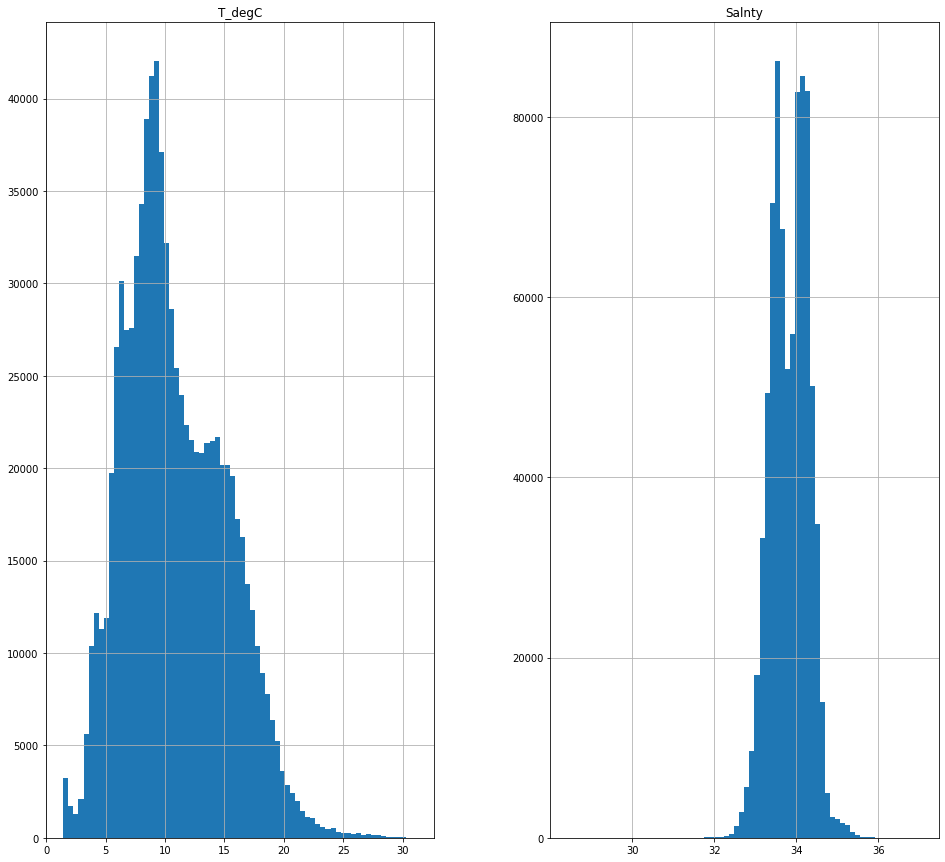

In [17]:
import matplotlib.pyplot as plt
temp_salinity_df.hist(bins=70, figsize=(16,15))
plt.show()

Let's see if the data contains Null values. There are 1.28 % null values for temperature and 5.8% null values for salinity. It's not much, especially for temperature and we could  drop the rows. But we will use SimpleImputer as an exercise instead. It has the benefit of storing the median value of each feature, which allows it to impute missing values not only in the training set but also in the validation set, test set, and any new data fed to the model. To use it, a SimpleImputer instance needs to be created. It will use the imputation strategy median, this will impute missing values in the dataset by replacing them with the median value of the corresponding feature.

In [18]:
mask = temp_salinity_df.isnull().any(axis=1)
temp_salinity_df[mask]


,T_degC,Salnty
17,8.45,NaN
98,9.97,NaN
129,10.20,NaN
222,12.23,NaN
264,NaN,33.95
...,...,...
810515,14.88,NaN
810524,15.10,NaN
811305,15.27,NaN
828253,13.58,NaN


In [19]:
print(temp_salinity_df.isnull().sum())
print(temp_salinity_df.count())
print((temp_salinity_df.isnull().sum()/temp_salinity_df.count())*100)

T_degC    10963
Salnty    47354
dtype: int64
T_degC    853900
Salnty    817509
dtype: int64
T_degC    1.283874
Salnty    5.792474
dtype: float64


In [20]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
# temp_salinity_df_imputed = temp_salinity_df.copy()
imputer.fit(temp_salinity_df)
# To verify
print(imputer.statistics_)
print(temp_salinity_df.median().values)
X = imputer.transform(temp_salinity_df)
temp_salinity_df_imputed = pd.DataFrame(X, columns=temp_salinity_df.columns,
 index=temp_salinity_df.index)
# Test if still null values
print(temp_salinity_df_imputed.isnull().sum())

#Overwrite original df
temp_salinity_df = temp_salinity_df_imputed.copy()

[10.06  33.863]
[10.06  33.863]
T_degC    0
Salnty    0
dtype: int64


##Create a Test Set
**Stratified sampling**


Stratified sampling is used to ensure that the dataset is representative of the population. For example, if the population is 50/50 - males/females, it is necessary to have a representative sample. To do so, the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population.


We will create a stratified train and test set as an exercise, which will be named *train_set* and *test_set*. We add an extra column for this, which divides the temperatures from the dataset into 5 different categories. At the end, we overwrite our dataset with the training dataset with *data = train_set.copy()*.

In [21]:
from sklearn.model_selection import train_test_split
temp_salinity_df["temp_cat"] = pd.cut(np.log(temp_salinity_df["T_degC"]), bins=5, labels=[1, 2, 3, 4, 5])

train_set, test_set = train_test_split(temp_salinity_df, test_size=0.2, stratify=temp_salinity_df["temp_cat"], random_state=42)

# tested the memory address to see if copy() was necessary
print(id(train_set))
train_set = train_set.copy()
test_set = test_set.copy()
print(id(train_set))

139674571894112
139674442269504


In [22]:
temp_salinity_df = train_set.copy()
temp_salinity_df.head(7)

,T_degC,Salnty,temp_cat
293956,9.580,33.9100,4
83413,13.880,33.8630,4
451139,11.870,34.3200,4
851494,5.967,34.2225,3
31958,17.420,33.8400,5
754173,15.270,32.9800,4
628698,19.220,33.4180,5


##Explore and Visualize the Data to Gain Insights
We will plot the correlation matrix to visually assess correlations.

array([[<Axes: xlabel='T_degC', ylabel='T_degC'>,
        <Axes: xlabel='Salnty', ylabel='T_degC'>],
       [<Axes: xlabel='T_degC', ylabel='Salnty'>,
        <Axes: xlabel='Salnty', ylabel='Salnty'>]], dtype=object)

Error in callback <function _draw_all_if_interactive at 0x7f08afca7b80> (for post_execute):


KeyboardInterrupt: ignored

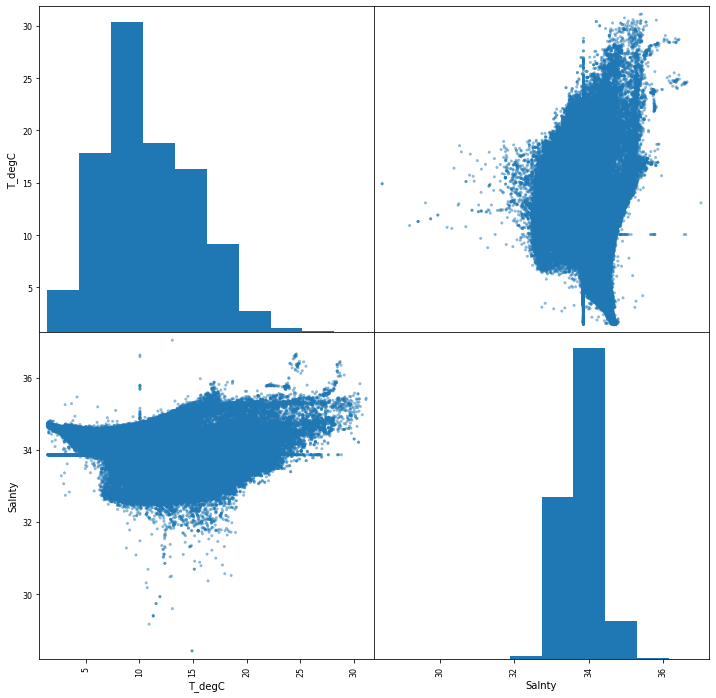

In [23]:
from pandas.plotting import scatter_matrix
# import matplotlib.pyplot as plt

# attributes = ['T_degC', 'Salnty']
scatter_matrix(temp_salinity_df, figsize=(12, 12))

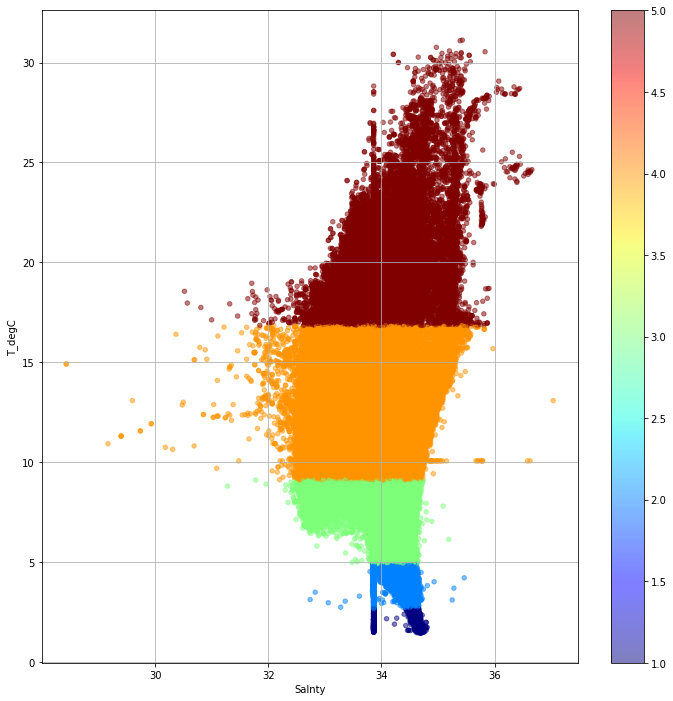

In [24]:
temp_salinity_df.plot(kind="scatter", x="Salnty", y="T_degC", grid=True, c=temp_salinity_df['temp_cat'], cmap='jet', alpha=0.5, colorbar=True,
 legend=True, sharex=False, figsize=(12,12))

plt.show()


We can observe, that there is an inverse relationship betwean salinity and temperature. It tends to converge around 34 lvl of salinity as temperatures grow, although at higher temperatures it is much more spreaded. We can also notice something happening at ~33.8 salinity level, here values cluster and disperse around the whole spectrum of temperature. Also, we notice a line of datapoints clustering around 10 °C, for different levels of salinity.

### Correlations

Since the dataset does not have  many features, it is quite easy to calculate the correlations of these. 
The correlation coefficient ranges from –1 to 1. A negative correlation indicates that as one variable increases, the other decreases, and vice-versa. 0 correlation indicates that there is no linear correlation. Obviously the correlation between temperature and itself is 1.
With salinity, it is negative and has a value of -0.45, it is not particularly strong.


In [25]:
corr_matrix = temp_salinity_df.corr()
corr_matrix["T_degC"].sort_values(ascending=False)

T_degC    1.000000
Salnty   -0.490369
Name: T_degC, dtype: float64

##Prepare the Data for Machine Learning Algorithms

In the first step, we separate our trainings dataset with our labeled dataset.

In [26]:
temp_salinity_df = train_set.drop("T_degC", axis=1)
temp_salinity_df_label = train_set[["T_degC"]].copy()

##Feature Scaling and Transformation

Min-max scaling and standardization are two  techniques used in ML to preprocess features before training a model. This will optimize the process. 

Min-max scaling is a method of normalizing the values of a numerical feature to a range between 0 and 1. This is done by subtracting the minimum value of the feature and then dividing by max-min.

Standardization transforms the values, such that they have a mean of 0 and a standard dev. of 1, (like in the standard normal distribution). This is done by subtracting the mean of the feature and then dividing by the standard deviation.
standardization = (x - mean(x)) / sdev(x)

A heavy tail in a distribution refers to a distribution where the tail (e.g., the values on the high end of the distribution) is longer and has more extreme values than a normal distribution. In other words, a heavy-tailed distribution has more outliers.
When using min-max scaling or standardization on a heavy-tailed distribution, we might get problems, because these techniques assume that the data is normally distributed or has a similar spread of values. However, in a heavy-tailed distribution, the presence of outliers or extreme values can greatly affect the scaling or standardization process. This can result in features that are improperly scaled or standardized, which can worsen the performance of ML.

Example: we have a dataset with a numerical feature that has a heavy-tailed distribution, with a few extreme values at the high end of the distribution.
In the case of min-max scaling, the presence of extreme values may cause the resulting scaled values to be biased towards 0 or 1.
In the case of standardization, the presence of extreme values may cause the standardized values to be skewed towards the mean.

###Transformation pipelines


We will use only one pipelines, as the dataset is much simpler, having sensibly less columns. We used the label pipeline to apply the logarithm to the temperature, because it had a long tail. For the temperature we just used StandardScaler

The pipeline  *default_num_pipeline*, standardizes numeric columns using StandardScaler.



label_pipeline takes the logarithm of of the target variable and does not apply any further transformations.


What arguments are in favor, and what arguments might be against?

Answer:

Arguments in favor of using these pipelines are that they can efficiently preprocess a dataset.

Arguments against using these pipelines might be that they can introduce information loss.

After a  brief reaserch, I found another approach is to use automated machine learning (AutoML) tools such as TPOT or Auto-sklearn. These can automatically search over a large space of potential preprocessing pipelines and machine learning models to find the best combination for a given dataset and problem. These tools can be especially useful for those with limited experience.


 

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
# from sklearn.preprocessing import OneHotEncoder

'''
def time(X):
 a =  pd.to_datetime("now") - X[X.columns[0]]
 a = a.dt.total_seconds()
 return a.to_frame()

date_pipeline = make_pipeline(
 FunctionTransformer(time),
 StandardScaler())
 '''

# cluster_simil = ClusterSimilarity(n_clusters=15, gamma=100., random_state=42)

default_num_pipeline = make_pipeline(StandardScaler())

'''log_pipeline = make_pipeline(
 FunctionTransformer(np.log),
 StandardScaler())'''

label_pipeline = make_pipeline(
 FunctionTransformer(np.log)) 

# cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
# ("log", log_pipeline, [""]),
# ("geo", cluster_simil, ["lat", "long"]),
# ("cat", cat_pipeline, ["", ""]),
# ("date", date_pipeline, [""]),
 ("normal", default_num_pipeline, ["Salnty"])
 ])

preprocessing_label = ColumnTransformer([
 ("log", label_pipeline, ["T_degC"])
 ])

How many features do we have for predicition?

Answer:

1

In [28]:
data_prepared = preprocessing.fit_transform(temp_salinity_df)
data_prepared.shape

(691890, 1)

##Select and Train a Model

###Linear Model

The following code determines a linear regression model

In [29]:
from sklearn.linear_model import LinearRegression

temp_salinity_df_label_transformed = preprocessing_label.fit_transform(temp_salinity_df_label)

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(temp_salinity_df, temp_salinity_df_label_transformed)

data_predictions = lin_reg.predict(temp_salinity_df)

In [30]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error

median_hat = np.median(np.exp(data_predictions))
median = np.median(np.exp(temp_salinity_df_label_transformed))

median_absolute_error = median_absolute_error(np.exp(temp_salinity_df_label_transformed), np.exp(data_predictions))
root_mean_squared_error = mean_squared_error(np.exp(temp_salinity_df_label_transformed), np.exp(data_predictions), squared=False)



print("median:",median)
print("predicted median:", median_hat)
print("mean absl error:", median_absolute_error)
print("root mean square error:", root_mean_squared_error)

median: 10.060000000000002
predicted median: 9.815765033982473
mean absl error: 1.686720590126856
root mean square error: 3.7501952738997484




The model performs quite well, as the predicted median values are good. The median value is 10.06, and the predicted median value by the model is 9.8 . This indicates that the model tends to slightly underestimate the water temperature, as the predicted median is lower than the actual median. Moreover, The RMSE of 1.68 is a good measure for the model quality. The median absolute error is 1.68, which means that on average, the model's predictions are off by approximately 1.68 °C  

###Random Forest Regressor (Took 11 min to run!)

We will now also compute a Radom Forrest model, automatically determining a cross validation with n = 10 on the training dataset. What happens during the cross validation?

Answer:

Scikit-Learn has a feature called "k_-fold cross-validation" . It randomly splits the training set into 10 nonoverlapping subsets called folds,
then it trains and evaluates the decision tree model 10 times, picking a different fold for evaluation every time and using the other 9 folds for training.

Why have I adjusted the R squared error with a separate function?

Answer:


If a model that uses logarithmic transformation, the dependent variable has been transformed to a logarithmic scale. This means that the traditional R squared, which is based on the untransformed dependent variable, would not be an appropriate.

The adjusted R squared takes the logarithmic scale and the number of independent variables into account, while penalizing for the number of independent variables. This makes it a useful for a model that uses logarithmic scale. By using the negative square root of the mean of the squared errors on the exponential scale as a scoring function, we are penalizing the model for large errors on the original scale.


 What is the function *np.ravel* doing?

 Answer:

 The np.ravel() function from NumPy is used to flatten an array / matrix into a one-dimensional array. Now it can be used by models that require a one-dimensional target variable, such as scikit-learn's RandomForestRegressor.



In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

temp_salinity_df_transformed = preprocessing_label.fit_transform(temp_salinity_df_label)

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg.fit(temp_salinity_df, np.ravel(temp_salinity_df_label_transformed))

def adjusted_rsquare(y_true, y_pred, **kwargs):
  return -np.sqrt(np.mean((np.exp(y_true)-np.exp(y_pred))**2))

neg_exp_root_mean_squared_error = make_scorer(adjusted_rsquare, greater_is_better=False)

forest_rmses = -cross_val_score(forest_reg, temp_salinity_df, np.ravel(temp_salinity_df_label_transformed),
 scoring=neg_exp_root_mean_squared_error, cv=10)



The following code outputs the RMSE for all 10 folds, compare it to the linear regression.

Answer:

The mean RMSE across all folds is approximately -3.19, which is  lower than the RMSE obtained from the linear regression model (3.75). This suggests that the random forest model is performing better than the linear regression model on this dataset. Additionally, the standard deviation of the RMSEs is small (0.018), which indicates that the performance of the model is consistent across different folds of the cross-validation process.

In [32]:
pd.Series(forest_rmses).describe()

count    10.000000
mean     -3.194724
std       0.018515
min      -3.223381
25%      -3.206821
50%      -3.198180
75%      -3.179733
max      -3.168421
dtype: float64

##Fine-Tune Your Model

###Grid Search & Randomized Search
Try to explain what the Grid Search and Random Search methods do.

Answer:

Grid Search and Random Search are methods for hyperparameter tuning.
Grid Search involves creating a grid of all possible hyperparameter values and then searching through that grid to find the optimal combination.

This method is easy to implement, but it can be  computationally expensive when dealing with a large number of hyperparameters or a large range of hyperparameter values.

Random Search, involves randomly sampling hyperparameters from a specified distribution and evaluating the model performance at each set of hyperparameters.

 What are the advantages of each method. 
 
 Answer:

 Grid Search:

- Exhaustive search: Explores all the possible combinations of hyperparameters in the search space.

- Easy to implement: Relatively simple to implement and does not require any complex coding or optimization algorithms.

- Clarity: produces clear and interpretable results.

Random Search:

- More efficient: More efficient than Grid Search, especially when the search space is large.

- Better results: May bring better results than Grid Search because it can explore more diverse hyperparameter combinations.

- It is possible that a combination of hyperparameters that are not adjacent in the search space can perform better than a combination that is adjacent.

- Flexibility: Random Search is more flexible.
 
 For which parameters would this make sense in our example?

 Answer:

For this model, given that it is an univariate linear regression we can use GridSearch as we don't have many variables, and hence a small hyperparameter space. So, we can tune hyperparameters such as the regularization strength for the linear regression model or "n_estimators", "max_features", "max_depth" for the random forest model.

###Evaluate Your System on the Test Set

I had trouble getting this to work. Maybe we can fix it in class.

Try to evaluate the final model with the test set. Compute the Median and 95% confidence interval of the root mean squared error and the median of the absolute error.

Remember to invert your results with the inverse functions you applied to the label variable as a preprocessing step. (The logarithm is the inverse function of the exponential function).

In [38]:
test_label_transformed = preprocessing_label.fit_transform(test_set[["T_degC"]].copy())

final_predictions = forest_reg.predict(test_set.drop("T_degC", axis=1))

m_a_e = median_absolute_error(np.exp(test_label_transformed), np.exp(final_predictions))
r_m_s_e = mean_squared_error(np.exp(test_label_transformed), np.exp(final_predictions), squared=False)


median_hat = np.median(np.exp(test_label_transformed))
median = np.median(np.exp(final_predictions))

print("Root mean squared error:", r_m_s_e)
print("Mean absolut error:", m_a_e)
print("predicted median:", median_hat)
print("median:", median)

TypeError: ignored

##Launch, Monitor, and Maintain Your System

What package and code can we use to save and reload our model?

Why is it possible that we need a monitoring code?

Monitoring is necessary, to verify performance on updated data or ir we need to train it again.

Try to save the weights of our model so that we can reload it at any time, without having to run the training again.

In [39]:
from joblib import dump, load

# Save the model
dump(forest_reg, 'regression_model_salinity_temperature')



['regression_model_salinity_temperature']

### Conclusion

We can say that there is a correlation between salinity and temperature. The random forest models seems to be better, although it took 11 minutes to run it, which surely can be optimized with more advanced knowledge. I am not confident about the values obtained, as there might have been errors with the transformations & scaling.

##Ideas for the Learning Portfolio
1) Adding a further model: In a few weeks we will learn neural networks, try to add this model!

2) Find a challenge on Kaggle for a regression dataset and use Chapter 2 and this colab to try to solve it. 